#### Student Name: Rajath Akshay Vanikul

Date: 12/06/2017

Version: 2.0

Environment: Python 3.6.0 and Anaconda 4.3.0 (64-bit)

Libraries used:
* pandas 0.19.2 (for data frame, included in Anaconda Python 3.6) 
* geopandas 5.0 (working with geospatial data in python, included in Anaconda Python 3.6)
* ast 2.6 (to create string or node structure, included in Anaconda Python 3.6) 
* math 3.7.3 (provides access to the mathematical functions, included in Anaconda Python 3.6)
* datetime 3.2 (module that supplies classes for manipulating dates and times, included in Anaconda Python 3.6)
* matplotlib 3.0.3 (data visualization and plotting, included in Anaconda Python 3.6)
* sklearn 20.2 (machine learning library, included in Anaconda Python 3.6)

## Table of Contents

1. [Introduction](#sec_1)
2. [Import libraries](#sec_2)
3. [Data Integration](#sec_3)
4. [Data reshaping](#sec_4)
5. [References](#sec_5)

## 1. Introduction <a class="anchor" id="sec_1"></a>

We are are provided multiple datasets in different sizes and the job is to create residential data in Victoria, Australia.

#### Task 1: Data Ingegration

It is a method in which information is obtained and mixed as an integrated shape and framework in different sizes and from different sources. It is a critical component of the method of data wrangling.

There are five datasets supplied as part of this task. The goal of the task is to integrate the datasets to generate the specified schema in the project specification. The following datasets were provided to us

1. **29498724.csv** <br>
Housing property data of Melbourne.
2. **vic_suburb_boundary** <br>
This contains the subfolders VIC LOCALITY POLYGON shp.dbf, VIC LOCALITY POLYGON shp.prj, VIC LOCALITY POLYGON shp.shp and VIC LOCALITY POLYGON shp.shx ID where VIC LOCALITY POLYGON shp.shp is used to get the names of the suburbs.
3. **gtfs** <br>
It contains information about the agency, calendar_dates, calendar - service_id, start date , end date and travel days is on weekdays or weekends,;routes - route name, route id ; shapes - distance travelled, shape id , shape lat and shape lon ; stop_times - trip id , arrival time , departure time, stop id , shape distance travelled ; stops - stop id , stop name,stop lat and stop lon; trips - route
4. **crimebylocationdatatable-yearending31march2016.xlsx** <br>
It contains information about the Apr - Mar reference period, Police Region, Police Service Area, Local Government Area,CSA Offence Division, CSA Offence Subdivision,Offence Count	,LGA  ERP and Victorian ERP.
5. **councils.txt** <br>
It has information about which all suburb belong to which all councils.


#### Task 2: Data Reshaping

This task is to build a linear model and study the effect of different normalisation and transformation methods on the predictors for melbourne housing price data.

## 2.  Import libraries <a class="anchor" id="sec_2"></a>

In [1]:
import pandas as pd
import geopandas as gpd
from ast import literal_eval
from math import sin,cos,sqrt,atan2,radians,log
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

## 3. Data Integration <a class="anchor" id="sec_3"></a>

In [2]:
# load the property data into a variable
data = pd.read_csv("29498724.csv")

#inspect the number of rows and columns in the df.
data.shape

(720, 12)

In [3]:
# removal of all the duplicated rows.
data.drop_duplicates(inplace=True)

#inspect the number of rows and columns in the df.
data.shape

(677, 12)

In [4]:
# inspect the sample of the data.
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID229233544,21 Ryder St,3,h,810000.0,8/04/2017,2.0,1.0,297.0,64.0,-37.73800,144.88650
1,ID857095596,1/142 Shields St,1,u,280000.0,4/03/2017,1.0,1.0,0.0,49.0,-37.78390,144.93470
2,ID417415267,6 MacKenzie St,3,h,718500.0,28/05/2016,1.0,6.0,807.0,44.0,-37.70400,144.98640
3,ID156702797,12 Ralph St,4,h,1300000.0,23/09/2017,2.0,3.0,650.0,59.0,-37.77352,145.09844
4,ID792883992,392 Station St,2,h,2400000.0,12/11/2016,2.0,0.0,413.0,119.0,-37.78750,144.97590


#### 3.1 SUBURB
This contains the subfolders VIC LOCALITY POLYGON shp.dbf, VIC LOCALITY POLYGON shp.prj, VIC LOCALITY POLYGON shp.shp and VIC LOCALITY POLYGON shp.shx ID where VIC LOCALITY POLYGON shp.shp is used to get the names of the suburbs.

In [5]:
# use of geopandas to read the spacial data.
df_suburb = gpd.read_file("vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp")

In [6]:
#executing exterior.coords will return the exterior coordinates as a list
df_suburb['geomlist'] = df_suburb['geometry'].apply(lambda x: list(x.exterior.coords))

In [7]:
# function accepts a set of coordinates and the “list-ified” boundary coordinates for a given neighbourhood 
# and checks whether the coordinates fall within the boundary.
# returns true if lat/long are within the bounds of the polygon.
def point_inside_polygon(lat,lng,poly):
    n = len(poly)
    inside =False
    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if lat > min(p1y,p2y):
            if lat <= max(p1y,p2y):
                if lng <= max(p1x,p2x):
                    if p1y != p2y:
                        xinters = (lat-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or lng <= xinters:
                        inside = not inside
        p1x,p1y = p2x,p2y
    return inside

In [8]:
# function to check lat and lon ro return suburb

def get_suburb(row):
    for ix,area in df_suburb.iterrows():
        is_in_area=False
        if row['Lattitude'] and row['Longtitude']:
            is_in_area = point_inside_polygon(row['Lattitude'], row['Longtitude'], area['geomlist'])
            if is_in_area:
                #found area, exit
                return area['VIC_LOCA_2']
    return "not available"

In [9]:
# populate the suburb column with respective suburb names.
data['Suburb'] = data.apply(lambda row: get_suburb(row), axis=1)

In [10]:
# inspect the sample of data with suburb data.
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb
0,ID229233544,21 Ryder St,3,h,810000.0,8/04/2017,2.0,1.0,297.0,64.0,-37.73800,144.88650,NIDDRIE
1,ID857095596,1/142 Shields St,1,u,280000.0,4/03/2017,1.0,1.0,0.0,49.0,-37.78390,144.93470,FLEMINGTON
2,ID417415267,6 MacKenzie St,3,h,718500.0,28/05/2016,1.0,6.0,807.0,44.0,-37.70400,144.98640,RESERVOIR
3,ID156702797,12 Ralph St,4,h,1300000.0,23/09/2017,2.0,3.0,650.0,59.0,-37.77352,145.09844,BULLEEN
4,ID792883992,392 Station St,2,h,2400000.0,12/11/2016,2.0,0.0,413.0,119.0,-37.78750,144.97590,CARLTON NORTH


#### 3.2 Extracting train information.

Extract information about train_station_id, distance_to_train_station and travel_min_to_CBD with defauly value as 0.

In [11]:
#Loading Melbourne GTFS 1 data
stops1=pd.read_csv('gtfs/1/google_transit/stops.txt',sep=",")
routes1=pd.read_csv('gtfs/1/google_transit/routes.txt',sep=",")
stop_time1=pd.read_csv('gtfs/1/google_transit/stop_times.txt',sep=",")
trips1=pd.read_csv('gtfs/1/google_transit/trips.txt',sep=",")
calendar1=pd.read_csv('gtfs/1/google_transit/calendar.txt',sep=",")

In [12]:
#Loading Melbourne GTFS 2 data
stops2=pd.read_csv('gtfs/2/google_transit/stops.txt',sep=",")
routes2=pd.read_csv('gtfs/2/google_transit/routes.txt',sep=",")
stop_time2=pd.read_csv('gtfs/2/google_transit/stop_times.txt',sep=",")
trips2=pd.read_csv('gtfs/2/google_transit/trips.txt',sep=",")
calendar2=pd.read_csv('gtfs/2/google_transit/calendar.txt',sep=",")

In [13]:
#concat similar dfs
stops=pd.concat([stops1,stops2])
routes=pd.concat([routes1,routes2])
stop_time=pd.concat([stop_time1,stop_time2])
trips=pd.concat([trips1,trips2])
calendar=pd.concat([calendar1,calendar2])

In [14]:
# Merging them into single DataFrame
result=routes.merge(trips,left_on='route_id',right_on='route_id',how='inner')
result=result.merge(stop_time,left_on='trip_id',right_on='trip_id',how='inner')
result=result.merge(stops,left_on='stop_id',right_on='stop_id',how='inner')
result=result.merge(calendar,left_on='service_id',right_on='service_id',how='inner')
result.shape

(947141, 32)

In [15]:
# filtering train info with trains travelling towards southern cross station on all weekdays between 7:00-9:30AM.

# direction id "0" will signify the train travelling towards southern cross station.
SC = result[result.direction_id == 0]

# filter it for trains that travel on all weekdays
SC = SC[(SC.monday == 1) & (SC.tuesday == 1) & (SC.wednesday == 1) & (SC.thursday == 1) & (SC.friday == 1)]

# filter it for departure time between 7:00-9:30AM.
SC = SC[(SC.departure_time >= '07:00:00') & (SC.departure_time <= '09:30:00')]

# Inspect the shape of the final filtered data frame.
SC.shape

(9549, 32)

In [16]:
# now extract all the trip ID of all the trains which stop at southern cross station and travel towards southern cross.

# stop IDs for southern cross station are 20043 and 22180.
SC_stop = result[result["stop_id"].isin([20043, 22180])]

# direction id "0" will signify the train travelling towards southern cross station.
SC_stop = SC_stop[SC_stop.direction_id == 0]

# Inspect the shape of the final filtered data frame.
SC_stop.shape

(16023, 32)

In [17]:
# extracting just the required columns of SC_stop. 
res=SC_stop[['route_id','trip_id','arrival_time','departure_time','stop_id','direction_id']]

# extracting just the required columns of all the trains towards southern cross station. 
SC_temp=SC[['route_id','trip_id','arrival_time','departure_time','stop_id','direction_id','stop_lat','stop_lon']]

# merge both the dataframes on trip_id.
same_trip = SC.merge(SC_stop,left_on=['trip_id'],right_on=['trip_id'],suffixes=('_1','_2'))

# filter df with dept time less than arrival time
same_trip = same_trip[same_trip.departure_time_1 <= same_trip.arrival_time_2]

# Inspect the shape of the final filtered data frame.
same_trip.shape

(4352, 63)

In [18]:
# calculate the travel time.
same_trip['time']=pd.to_datetime(same_trip['arrival_time_2'])-pd.to_datetime(same_trip['departure_time_1'])

# convert to minutes.
same_trip['time']=same_trip['time'].dt.total_seconds()/60

# Inspect the shape of the final filtered data frame.
same_trip.shape

(4352, 64)

In [19]:
# delete all the duplicate rows
same_trip.drop_duplicates(inplace=True)

# Inspect the shape of the final filtered data frame.
same_trip.shape

(4352, 64)

In [20]:
# A function to calculate the distance using Haversine formula.

def distance(lat,med_lat,lon,med_lon):
    R = 6378.0
    lat,lon,med_lat,med_lon = map(radians,[lat,lon,med_lat,med_lon]) # calculate the radians
    # Haversine formula
    h = sin((med_lat - lat)/2)**2 + cos(lat) * cos(med_lat) * sin((med_lon - lon)/2)**2
    c = 2 * atan2(sqrt(h),sqrt(1 - h))
    dist = R*c
    # return the distance
    return dist

In [21]:
# A function to calculate all the distances and identify the optimum station for the co-ordinate. 
dist_list = []
def Station(item):
    dist_dict={} # list to store all the distance values calculated
    
    
    # iterate thorough  all the train details.
    for i,j in same_trip.iterrows():
        d = (distance(item["Lattitude"],j.stop_lat_1,item["Longtitude"],j.stop_lon_1))
        dist_dict[j.stop_id_1] = d
    
    least = min(dist_dict.items(), key=lambda x: x[1])
    return least

In [22]:
# determine the station ID and distance for each record in df
data["Temp"] = data.apply(Station,axis=1)

# use two different columns to store train ID and distance to train startion.
data[['train_station_id', 'distance_to_train_station']] = pd.DataFrame(data['Temp'].tolist(), index=data.index) 

In [23]:
# Calculating travel time for the journey between train station to southern cross station.

# groupby each stop ID and average the times.
a = same_trip.groupby('stop_id_1')['time'].mean()

# converting into a df
avg_time = pd.DataFrame({'stop_id':a.index, 'travel_min_to_CBD':a.values})

# inspecting sample of averaged time.
avg_time.head()

,stop_id,travel_min_to_CBD
0,17204,56.750000
1,19841,3.869565
2,19842,5.043478
3,19843,6.231884
4,19854,3.481013


In [24]:
# merging the calculated time to our original df to get the average time.
data = data.merge(avg_time,left_on='train_station_id',right_on='stop_id',how='left')

# display the sample of the df
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,Temp,train_station_id,distance_to_train_station,stop_id,travel_min_to_CBD
0,ID229233544,21 Ryder St,3,h,810000.0,8/04/2017,2.0,1.0,297.0,64.0,-37.73800,144.88650,NIDDRIE,"(22253, 3.2943971930066613)",22253,3.294397,22253,18.333333
1,ID857095596,1/142 Shields St,1,u,280000.0,4/03/2017,1.0,1.0,0.0,49.0,-37.78390,144.93470,FLEMINGTON,"(22239, 2.5655167549405453)",22239,2.565517,22239,7.000000
2,ID417415267,6 MacKenzie St,3,h,718500.0,28/05/2016,1.0,6.0,807.0,44.0,-37.70400,144.98640,RESERVOIR,"(20009, 2.081588772714229)",20009,2.081589,20009,35.200000
3,ID156702797,12 Ralph St,4,h,1300000.0,23/09/2017,2.0,3.0,650.0,59.0,-37.77352,145.09844,BULLEEN,"(20015, 8.982659528924438)",20015,8.982660,20015,23.300000
4,ID792883992,392 Station St,2,h,2400000.0,12/11/2016,2.0,0.0,413.0,119.0,-37.78750,144.97590,CARLTON NORTH,"(20019, 1.5284708874126687)",20019,1.528471,20019,18.300000


#### 3.3 Determining Overpriced properties.

Create a column with values "True" if the property is over priced and "False" if not.

In [25]:
# read the council data to a dictionary
council = {}
with open("councils.txt") as f:
    for line in f:
        (key, val) = line.split(':')
        val = [x.upper() for x in literal_eval(val.strip())]
        council[key.strip()] = val
        
# calculate the council names for each record in property data.
temp = []
for i,j in data.iterrows():
    for x in council:
        if j.Suburb in council[x]:
            temp.append(x)
            
# create a column to store the council for each record.
data["council"] = temp

In [26]:
# determine the selling year of the property.
data["Year"] = (data.Date.str[-4:]).astype(int) 

In [27]:
#find median price based on features(bedrooms, bathrooms, parking_space, and property_type) n then if price >median place in new column as True

# default value
data['over_priced?'] = -1
for index,row in data.iterrows():
    temp = data[(data['Rooms']== row['Rooms']) & (data['Bathroom'] == row['Bathroom']) & (data['Car'] == row['Car']) & (data['Type'] == row['Type']) & (data['Year']==row['Year'])] 
    if row['Price'] > temp['Price'].median(): # price of the property greater than the median price
        data.iloc[index, data.columns.get_loc('over_priced?')] = True
    else:
        data.iloc[index, data.columns.get_loc('over_priced?')] = False 

#### 3.4 Extracting crime data

Determine crime A, crime B and crime C average values of each record of property data.

In [28]:
# read the crime excel file to a variable.
crime = pd.read_excel("crimebylocationdatatable-yearending31march2016.xlsx",sheet_name=1)

# extract just the table in the sheet.
crime = crime.iloc[17:]
crime = crime.drop(crime.columns[0], axis=1)
crime.columns = crime.iloc[0]
crime = crime.iloc[1:]

# inspect the shape of the variable
crime.shape

(9085, 9)

In [29]:
# inspecting sample of the variable
crime.head()

17,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
18,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
19,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
20,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
21,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
22,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


In [30]:
# extract information just about crime A.
crime_A = crime[crime["CSA Offence Division"] == 'A Crimes against the person']
crime_A = crime_A.groupby(["Local Government Area","Apr - Mar reference period"])["Offence Count"].agg(sum)
crime_A = crime_A.reset_index()
crime_A.head()

,Local Government Area,Apr - Mar reference period,Offence Count
0,ALPINE,2012,72
1,ALPINE,2013,78
2,ALPINE,2014,85
3,ALPINE,2015,99
4,ALPINE,2016,93


In [31]:
# extract information just about crime B.
crime_B = crime[crime["CSA Offence Division"] == 'B Property and deception offences']
crime_B = crime_B.groupby(["Local Government Area","Apr - Mar reference period"])["Offence Count"].agg(sum)
crime_B = crime_B.reset_index()
crime_B.head()

,Local Government Area,Apr - Mar reference period,Offence Count
0,ALPINE,2012,227
1,ALPINE,2013,215
2,ALPINE,2014,235
3,ALPINE,2015,306
4,ALPINE,2016,239


In [32]:
# extract information just about crime C.
crime_C = crime[crime["CSA Offence Division"] == 'C Drug offences']
crime_C = crime_C.groupby(["Local Government Area","Apr - Mar reference period"])["Offence Count"].agg(sum)
crime_C = crime_C.reset_index()
crime_C.head()

,Local Government Area,Apr - Mar reference period,Offence Count
0,ALPINE,2012,37
1,ALPINE,2013,41
2,ALPINE,2014,28
3,ALPINE,2015,42
4,ALPINE,2016,40


In [33]:
# calculating the average values for each crime type based on past 3 years
data['crime_A_average'] = -1
data['crime_B_average'] = -1
data['crime_C_average'] = -1
for index,row in data.iterrows():
    temp_A = crime_A[((crime_A["Apr - Mar reference period"]==row['Year']-1)| (crime_A["Apr - Mar reference period"]==row['Year']-2)| (crime_A["Apr - Mar reference period"]==row['Year']-3)) & (crime_A['Local Government Area'] == row['council'])] #area - check if council or area
    temp_B = crime_B[((crime_B["Apr - Mar reference period"]==row['Year']-1)| (crime_B["Apr - Mar reference period"]==row['Year']-2)| (crime_B["Apr - Mar reference period"]==row['Year']-3)) & (crime_B['Local Government Area'] == row['council'])]
    temp_C = crime_C[((crime_C["Apr - Mar reference period"]==row['Year']-1)| (crime_C["Apr - Mar reference period"]==row['Year']-2)| (crime_C["Apr - Mar reference period"]==row['Year']-3)) & (crime_C['Local Government Area'] == row['council'])]
    
    # store the values accordingly.
    data.loc[index,'crime_A_average'] = temp_A["Offence Count"].mean()
    data.loc[index,'crime_B_average'] = temp_B["Offence Count"].mean()
    data.loc[index,'crime_C_average'] = temp_C["Offence Count"].mean()

In [35]:
# drop all the excess columns
data.drop(["Temp","stop_id","council","Year"],axis=1,inplace=True)
data = data.rename({'Landsize': 'LandSize', 'Lattitude': 'Latitude','Longtitude':'Longitude'}, axis=1)
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,LandSize,Age,Latitude,Longitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average
0,ID229233544,21 Ryder St,3,h,810000.0,8/04/2017,2.0,1.0,297.0,64.0,-37.73800,144.88650,NIDDRIE,22253,3.294397,18.333333,False,84.333333,293.333333,23.000000
1,ID857095596,1/142 Shields St,1,u,280000.0,4/03/2017,1.0,1.0,0.0,49.0,-37.78390,144.93470,FLEMINGTON,22239,2.565517,7.000000,False,2047.666667,9171.000000,742.333333
2,ID417415267,6 MacKenzie St,3,h,718500.0,28/05/2016,1.0,6.0,807.0,44.0,-37.70400,144.98640,RESERVOIR,20009,2.081589,35.200000,False,824.666667,1890.333333,159.333333
3,ID156702797,12 Ralph St,4,h,1300000.0,23/09/2017,2.0,3.0,650.0,59.0,-37.77352,145.09844,BULLEEN,20015,8.982660,23.300000,False,941.333333,5813.000000,575.666667
4,ID792883992,392 Station St,2,h,2400000.0,12/11/2016,2.0,0.0,413.0,119.0,-37.78750,144.97590,CARLTON NORTH,20019,1.528471,18.300000,False,3703.666667,18944.000000,2039.333333


In [65]:
# write the data into an output csv.

data.to_csv("29498724_solution.csv")

## 4. Data reshaping <a class="anchor" id="sec_4"></a>

This task is to build a linear model and study the effect of different normalisation and transformation methods on the predictors for melbourne housing price data.

In [37]:
# extracting the 4 columns mentioned to perform transforming and scaling along with the target variable "Price"
model_data = data[['Rooms', 'crime_C_average','travel_min_to_CBD','Age','Price']]

# splitting train and test data
x_train, x_test, y_train, y_test = train_test_split(model_data[['Rooms', 'crime_C_average', 'travel_min_to_CBD','Age']],
                                                    model_data.Price,test_size=0.2,random_state=1)

In [38]:
# training linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

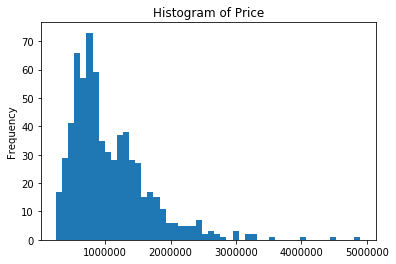

In [39]:
model_data['Price'].plot(kind='hist',bins=50,title='Histogram of Price')

In [40]:
# Determine the R square value of predicted value
print("R2 score : ",model.score(x_test, y_test))

R2 score :  0.3099222565922032


### 4.1 Perform Normalisations

#### 4.1.1 Z score

In [41]:
model_data.describe()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price
count,677.000000,677.000000,677.000000,677.000000,6.770000e+02
mean,2.923191,450.655342,20.996613,56.903988,1.071992e+06
std,0.932647,413.564412,10.933039,36.975619,6.040169e+05
min,1.000000,1.000000,0.000000,2.000000,2.500000e+05
25%,2.000000,159.333333,16.000000,25.000000,6.500000e+05
50%,3.000000,338.333333,20.000000,49.000000,8.950000e+05
75%,3.000000,575.666667,24.200000,81.000000,1.352000e+06
max,7.000000,2042.333333,66.000000,159.000000,4.900000e+06


In [42]:
# performing z score transformation on the predictors
std_scale = preprocessing.StandardScaler().fit(model_data[['Rooms', 'crime_C_average','travel_min_to_CBD','Age']])
df_std = std_scale.transform(model_data[['Rooms', 'crime_C_average','travel_min_to_CBD','Age']])
df_std

array([[ 0.08241726, -1.03483648, -0.24377937,  0.19205246],
       [-2.06360136,  0.70579973, -1.28115911, -0.21392021],
       [ 0.08241726, -0.70493833,  1.30008577, -0.34924443],
       ...,
       [ 1.15542657, -0.70171194, -0.52143101, -1.21531945],
       [ 1.15542657,  0.17505894, -0.52143101, -0.07859599],
       [-0.99059205, -0.89206882, -0.70449802, -1.02586554]])

In [43]:
# appending normalized attributes into the df
model_data['rooms_norm'] = df_std[:,0]
model_data['crime_norm'] = df_std[:,1]
model_data['travel_time_norm'] = df_std[:,2]
model_data['age_norm'] = df_std[:,3]

/Users/Rajath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Rajath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Rajath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [44]:
# notice that the std is  close to 1 and mean is close to 0.
model_data.describe() # check that μ = 0 and σ = 1... approx

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,rooms_norm,crime_norm,travel_time_norm,age_norm
count,677.000000,677.000000,677.000000,677.000000,6.770000e+02,6.770000e+02,6.770000e+02,6.770000e+02,6.770000e+02
mean,2.923191,450.655342,20.996613,56.903988,1.071992e+06,7.592810e-17,-2.295882e-17,1.666154e-16,-1.738311e-17
std,0.932647,413.564412,10.933039,36.975619,6.040169e+05,1.000739e+00,1.000739e+00,1.000739e+00,1.000739e+00
min,1.000000,1.000000,0.000000,2.000000,2.500000e+05,-2.063601e+00,-1.088072e+00,-1.921894e+00,-1.485968e+00
25%,2.000000,159.333333,16.000000,25.000000,6.500000e+05,-9.905920e-01,-7.049383e-01,-4.573576e-01,-8.634765e-01
50%,3.000000,338.333333,20.000000,49.000000,8.950000e+05,8.241726e-02,-2.717958e-01,-9.122353e-02,-2.139202e-01
75%,3.000000,575.666667,24.200000,81.000000,1.352000e+06,8.241726e-02,3.025013e-01,2.932172e-01,6.521548e-01
max,7.000000,2042.333333,66.000000,159.000000,4.900000e+06,4.374454e+00,3.851528e+00,4.119318e+00,2.763213e+00


In [45]:
# split train and test on the normalized predictors
x_train, x_test, y_train, y_test = train_test_split(model_data[['rooms_norm', 'crime_norm', 
                                                                'travel_time_norm','age_norm']],
                                                    model_data.Price,test_size=0.2,random_state=1)

# fit the finear model to determine change.
model = LinearRegression()
model.fit(x_train, y_train)
print("R2 score : ",model.score(x_test, y_test))

R2 score :  0.3099222565922035


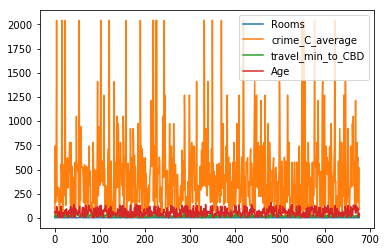

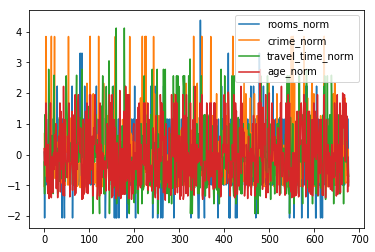

In [46]:
%matplotlib inline
model_data[['Rooms', 'crime_C_average','travel_min_to_CBD','Age']].plot()
model_data[['rooms_norm', 'crime_norm','travel_time_norm','age_norm']].plot()

We can notice that all the predictors have been normalised around the value 0.<br>
However,
There is no difference in R square value of the model compared to the initial one because the data and the variance remains the same even after normalisation  


#### 4.1.2 MinMax normalisation

In [47]:
# Performing minmax scaling on the data
minmax_scale = preprocessing.MinMaxScaler().fit(model_data
                                                [['Rooms', 'crime_C_average','travel_min_to_CBD','Age']])
df_minmax = minmax_scale.transform(model_data[['Rooms', 'crime_C_average','travel_min_to_CBD','Age']]) 
df_minmax

array([[0.33333333, 0.01077727, 0.27777778, 0.39490446],
       [0.        , 0.36316133, 0.10606061, 0.29936306],
       [0.33333333, 0.07756368, 0.53333333, 0.26751592],
       ...,
       [0.5       , 0.07821685, 0.23181818, 0.06369427],
       [0.5       , 0.25571522, 0.23181818, 0.33121019],
       [0.16666667, 0.03967995, 0.20151515, 0.10828025]])

In [48]:
# appending normalized attributes into the df
model_data['rooms_minmax'] = df_minmax[:,0]
model_data['crime_minmax'] = df_minmax[:,1]
model_data['travel_time_minmax'] = df_minmax[:,2]
model_data['age_minmax'] = df_minmax[:,3]

/Users/Rajath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Rajath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Rajath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [49]:
# we can notice the values scaled between maximum and minimum values of 0,1.
model_data.describe() # values are between 0 and 1.

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,rooms_norm,crime_norm,travel_time_norm,age_norm,rooms_minmax,crime_minmax,travel_time_minmax,age_minmax
count,677.000000,677.000000,677.000000,677.000000,6.770000e+02,6.770000e+02,6.770000e+02,6.770000e+02,6.770000e+02,677.000000,677.000000,677.000000,677.000000
mean,2.923191,450.655342,20.996613,56.903988,1.071992e+06,7.592810e-17,-2.295882e-17,1.666154e-16,-1.738311e-17,0.320532,0.220275,0.318131,0.349707
std,0.932647,413.564412,10.933039,36.975619,6.040169e+05,1.000739e+00,1.000739e+00,1.000739e+00,1.000739e+00,0.155441,0.202595,0.165652,0.235513
min,1.000000,1.000000,0.000000,2.000000,2.500000e+05,-2.063601e+00,-1.088072e+00,-1.921894e+00,-1.485968e+00,0.000000,0.000000,0.000000,0.000000
25%,2.000000,159.333333,16.000000,25.000000,6.500000e+05,-9.905920e-01,-7.049383e-01,-4.573576e-01,-8.634765e-01,0.166667,0.077564,0.242424,0.146497
50%,3.000000,338.333333,20.000000,49.000000,8.950000e+05,8.241726e-02,-2.717958e-01,-9.122353e-02,-2.139202e-01,0.333333,0.165251,0.303030,0.299363
75%,3.000000,575.666667,24.200000,81.000000,1.352000e+06,8.241726e-02,3.025013e-01,2.932172e-01,6.521548e-01,0.333333,0.281515,0.366667,0.503185
max,7.000000,2042.333333,66.000000,159.000000,4.900000e+06,4.374454e+00,3.851528e+00,4.119318e+00,2.763213e+00,1.000000,1.000000,1.000000,1.000000


In [50]:
# train the model on the minmax scaled values
x_train, x_test, y_train, y_test = train_test_split(model_data[['rooms_minmax', 'crime_minmax', 
                                                                'travel_time_minmax','age_minmax']],
                                                    model_data.Price,test_size=0.2,random_state=1)
model = LinearRegression()
model.fit(x_train, y_train)
print("R2 score : ",model.score(x_test, y_test))


R2 score :  0.3099222565922034


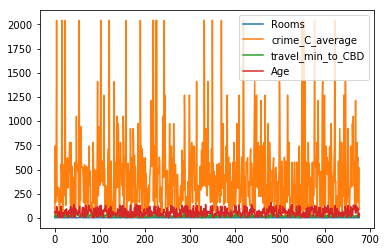

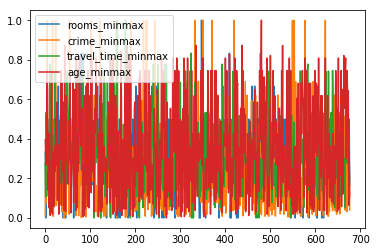

In [51]:
model_data[['Rooms', 'crime_C_average','travel_min_to_CBD','Age']].plot()
model_data[['rooms_minmax', 'crime_minmax','travel_time_minmax','age_minmax']].plot()

We can notice that all the predictors have been normalised between 0 and 1. <br>
However, There is no difference in R square value of the model compared to the initial one because the data and the variance remains the same even after normalisation.

### 4.2 Perform Transformations

Check scatter plots of the all the predictors

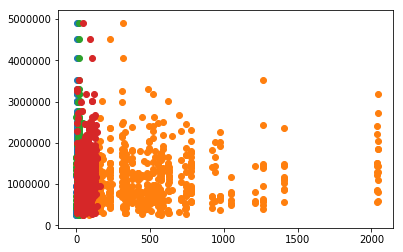

In [52]:
# scatter plot all predictor vs Price
plt.scatter(model_data["Rooms"], model_data["Price"]),
plt.scatter(model_data["crime_C_average"], model_data["Price"]),
plt.scatter(model_data["travel_min_to_CBD"], model_data["Price"]),
plt.scatter(model_data["Age"], model_data["Price"])

#### 4.2.1 Root transformation

In [53]:
# initialising columns in df
model_data['rooms_sqrt'] = None
model_data['crimes_sqrt'] = None
model_data['times_sqrt'] = None
model_data['age_sqrt'] = None

/Users/Rajath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Rajath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Rajath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [54]:
# computing root transformation on all the predictors
i=0
for row in model_data.iterrows(): 
    model_data['rooms_sqrt'].at[i] = sqrt(model_data.Rooms[i])
    model_data['crimes_sqrt'].at[i] = sqrt(model_data.crime_C_average[i])
    model_data['times_sqrt'].at[i] = sqrt(model_data.travel_min_to_CBD[i])
    model_data['age_sqrt'].at[i] = sqrt(model_data.Age[i])
    i += 1

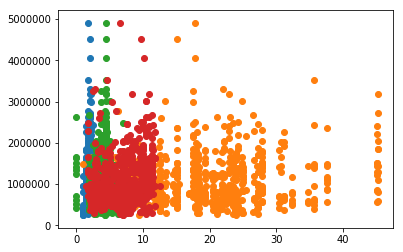

In [55]:
# scatter plot the transformed predictors
plt.scatter(model_data["rooms_sqrt"], model_data["Price"]), # blue
plt.scatter(model_data["crimes_sqrt"], model_data["Price"]), # orange
plt.scatter(model_data["times_sqrt"], model_data["Price"]), # green
plt.scatter(model_data["age_sqrt"], model_data["Price"]) # red

In [56]:
# develop linear model on the root transformed predictors

x_train, x_test, y_train, y_test = train_test_split(model_data[['rooms_sqrt', 'crimes_sqrt', 
                                                                'times_sqrt','age_sqrt']],
                                                    model_data.Price,test_size=0.2,random_state=1)
model = LinearRegression()
model.fit(x_train, y_train)
print("R2 score : ",model.score(x_test, y_test))

R2 score :  0.27719936917294385


We can easily notice that the data points are scattered all over the range. The root transformation has helped the linear model to predict it better and reduce the R square error.

#### 4.2.2 log transformation

In [57]:
# initialising columns in df
model_data['rooms_log'] = None
model_data['crimes_log'] = None
model_data['times_log'] = None
model_data['age_log'] = None

/Users/Rajath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Rajath/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
# computing root transformation on all the predictors
# in this process, we cant apply log transfrom on travel time
i=0
for row in model_data.iterrows(): 
    model_data['rooms_log'].at[i] = log(model_data.Rooms[i])
    model_data['crimes_log'].at[i] = log(model_data.crime_C_average[i])
    model_data['age_log'].at[i] = log(model_data.Age[i])
    i += 1

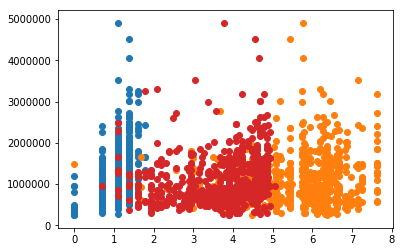

In [59]:
# develop linear model on the log transformed predictors
plt.scatter(model_data["rooms_log"], model_data["Price"]),
plt.scatter(model_data["crimes_log"], model_data["Price"]),
plt.scatter(model_data["times_log"], model_data["Price"]),
plt.scatter(model_data["age_log"], model_data["Price"])

In [60]:
x_train, x_test, y_train, y_test = train_test_split(model_data[['rooms_log', 'crimes_log','age_log']],
                                                    model_data.Price,test_size=0.2,random_state=1)
model = LinearRegression()
model.fit(x_train, y_train)
print("R2 score : ",model.score(x_test, y_test))

R2 score :  0.19291242223148544


We can notice that the data points are scattered and distributed uniformly over the range. The log transformation has helped the linear model to predict and thus the R square error has significantly decreased compared to the previous one.

#### 4.2.3 square power transformation 

In [61]:
# initialising columns in df
model_data['rooms_pow'] = None
model_data['crimes_pow'] = None
model_data['times_pow'] = None
model_data['age_pow'] = None

In [62]:
# computing root transformation on all the predictors
i=0
for row in model_data.iterrows(): 
    model_data['rooms_pow'].at[i] = pow(model_data.Rooms[i],2)
    model_data['crimes_pow'].at[i] = pow(model_data.crime_C_average[i],2)
    model_data['times_pow'].at[i] = pow(model_data.travel_min_to_CBD[i],2)
    model_data['age_pow'].at[i] = pow(model_data.Age[i],2)
    i += 1

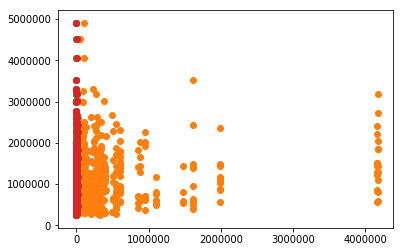

In [63]:
# scatter plot of powered transformed predictors.
plt.scatter(model_data["rooms_pow"], model_data["Price"]), # blue
plt.scatter(model_data["crimes_pow"], model_data["Price"]), # orange
plt.scatter(model_data["times_pow"], model_data["Price"]), # green
plt.scatter(model_data["age_pow"], model_data["Price"]) # red

In [64]:
# develop linear model on the root transformed predictors

x_train, x_test, y_train, y_test = train_test_split(model_data[['rooms_pow', 'crimes_pow', 
                                                                'times_pow','age_pow']],
                                                    model_data.Price,test_size=0.2,random_state=1)
model = LinearRegression()
model.fit(x_train, y_train)
print("R2 score : ",model.score(x_test, y_test))

R2 score :  0.30468188085072034


We can notice that the data points are skewed towards one end. The square power transformation has not helped the linear model to predict and thus the R square error has increased compared to the previous one.

**To conclude, Log transformation was the best transformation that helped linear model in predicting the target with least error.** 

## 5. References <a class="anchor" id="sec_5"></a>

* https://medium.com/dataexplorations/working-with-open-data-shape-files-using-geopandas-how-to-match-up-your-data-with-the-areas-9377471e49f2
* https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606
* http://geopandas.org/
* https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html